# Stretch Reinforcement Learning with DM_Control and PPO

References:
- Google Deepmind [DM_Control Colab](https://colab.research.google.com/github/google-deepmind/dm_control/blob/main/tutorial.ipynb#scrollTo=JHSvxHiaopDb)
- TowardsAI [Quick Start Robotics and Reinforcement Learning with MuJoCo](https://towardsai.net/p/artificial-intelligence/quick-start-robotics-and-reinforcement-learning-with-mujoco) 


<!-- Internal installation instructions. -->

### Getting Started

## Install the dependencies using

- Run `uv pip install -e ".[rlearning]"`

In [1]:
try:
  import google.colab
  RUNNING_IN_COLAB = True
except:
  RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
  !pip install -q dm_control

  import distutils.util
  import os
  import subprocess
  if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)

  print('Installing dm_control...')

  # Configure dm_control to use the EGL rendering backend (requires GPU)
  %env MUJOCO_GL=egl

  print('Checking that the dm_control installation succeeded...')
  try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
  except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
  else:
    del pixels, suite

  !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [3]:
# From the Google Deepmind dm_control colab notebook:
# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

%matplotlib notebook

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [4]:
import time
import cv2
from stretch_mujoco.enums.actuators import Actuators

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

arm_joints = ['joint_arm_l0', 'joint_arm_l1', 'joint_arm_l2', 'joint_arm_l3', 'joint_gripper_slide', 'joint_lift', 'joint_wrist_pitch', 'joint_wrist_roll', 'joint_wrist_yaw']
finger_joints = ['joint_gripper_finger_left_open', 'joint_gripper_finger_right_open',] #'rubber_left_x', 'rubber_left_y', 'rubber_right_x', 'rubber_right_y']

class StretchPushCubeTraining:
    def __init__(self, physics: mujoco.Physics, push_cube_by=np.array([0.5, 0.0, 00])):
        self.physics = physics
        self.target_position =  self._get_cube_pos() + push_cube_by

        # Define state size: joint positions, joint velocities, 3 object1 position
        self.state_size = len(arm_joints) * 2 + 3
        
        # Define action size: 7 continuous joint actions
        self.action_size = len(arm_joints)  # num joints to control

        self.frames = []
        self.render_rate = 1/30 #1/Hz
        self.time_last_render = time.perf_counter()
        self.last_step_time = time.perf_counter()

        self.current_distance_to_target = float('inf')

    def _get_cube_id(self):
        return self.physics.model.name2id("object1", "body")
    def _get_cube_pos(self):
        return self.physics.data.xpos[self._get_cube_id()]
    def _get_cube_original_pos(self):
        return self.physics.model.body("object1").pos
    
    def arm_joint_pos(self):
        return self.physics.named.data.qpos[arm_joints]
    def arm_joint_vel(self):
        return self.physics.named.data.qvel[arm_joints]
    
    def reset(self):
        # Reset the simulation
        self.frames = []
        self.physics.reset_context()
        
        self.current_distance_to_target = float('inf')

        return np.concatenate([self.arm_joint_pos(), self.arm_joint_vel(), self._get_cube_original_pos()])
        

    def reward(self):
        # Calculate the reward (negative distance to target position of object1)
        object_pos = self._get_cube_pos()
        self.current_distance_to_target = np.linalg.norm(object_pos - self.target_position)
        return -self.current_distance_to_target  # Negative because we want to minimize the distance

    def check_is_done(self):
        return self.current_distance_to_target < 0.05  # Done if the object is close enough to the target

    def step(self, action):

        time_until_next_step = self.physics.model.opt.timestep - (time.perf_counter() - self.last_step_time)
        if time_until_next_step > 0:
            # Sleep to match the timestep.
            time.sleep(time_until_next_step)

        # Apply the action to the joints
        for index, name in enumerate([j.name for j in Actuators.get_arm_joints()]):
            self.physics.data.actuator(name).ctrl = action[index]
        
        # Step the simulation forward
        self.physics.step()

        self.last_step_time = time.perf_counter()

        # Get the current state (qpos, qvel, object1 position)
        state = np.concatenate([self.arm_joint_pos(), self.arm_joint_vel(), self._get_cube_pos()])

        return state

    def render(self):
        
        elapsed = time.perf_counter() - self.time_last_render
        if elapsed > self.render_rate:
            self.time_last_render = time.perf_counter()

            pixels = self.physics.render(scene_option=scene_option)

            self.frames.append(pixels)



In [5]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

In [6]:

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

# PPO Algorithm Implementation
class PPO:
    def __init__(self, state_size, action_size, hidden_size=64, lr=3e-4, gamma=0.99, lam=0.95, epsilon=0.2):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        
        # Create policy network (actor) and value network (critic)
        self.actor = self.create_network()
        self.critic = self.create_critic()
        
        # Create optimizers for the actor and critic
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

    def create_network(self):
        # Shared fully connected neural network
        return nn.Sequential(
            nn.Linear(self.state_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.action_size),
        )
    def create_critic(self):
        return nn.Sequential(
            layer_init(nn.Linear(np.array(self.state_size).prod(), self.hidden_size)),
            nn.Tanh(),
            layer_init(nn.Linear(self.hidden_size, self.hidden_size)),
            nn.Tanh(),
            layer_init(nn.Linear(in_features=self.hidden_size, out_features=1), std=1.0),
        )

    def select_action(self, state):
        # Policy network to select actions (continuous actions)
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action = self.actor(state_tensor).detach().numpy()
        return action

    def compute_returns(self, rewards, values, next_value, done):
        # Generalized Advantage Estimation (GAE)
        returns = []
        advantages = []
        advantage = 0
        for reward, value, next_value_ in zip(reversed(rewards), reversed(values), [next_value] + values[:-1]):
            delta = reward + self.gamma * next_value_ * (1 - done) - value
            advantage = delta + self.gamma * self.lam * advantage
            advantages.append(advantage)
            returns.append(advantage + value)
            next_value = next_value_

        return list(reversed(returns)), list(reversed(advantages))

    def update(self, states, actions, returns, advantages):
        
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.float32)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32)

        # Compute the current value and action probability
        values = self.critic(states_tensor).squeeze()
        actions_pred = self.actor(states_tensor)

        # Calculate value loss
        value_loss = (returns_tensor - values).pow(2).mean()

        # Calculate policy loss with the clipped objective
        action_log_probs = torch.log(actions_pred + 1e-10)
        old_action_log_probs = torch.log(actions_tensor + 1e-10)
        ratio = torch.exp(action_log_probs - old_action_log_probs)
        surrogate_loss = ratio.T * advantages_tensor
        clipped_loss = torch.clamp(ratio.T, 1 - self.epsilon, 1 + self.epsilon) * advantages_tensor
        policy_loss = -torch.min(surrogate_loss, clipped_loss).mean()

        # Total loss
        loss = policy_loss + value_loss

        # Optimize the networks
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()


In [7]:
# Training Loop
def train(env:StretchPushCubeTraining, agent: PPO, episodes=1000, batch_size=64, steps_per_update=2048):
    for episode in range(episodes):
        states, actions, rewards, values = [], [], [], []
        next_state = env.reset()
        
        for _ in range(steps_per_update):
            state = next_state
            action = agent.select_action(state)
            next_state = env.step(action)
            reward = env.reward()

            env.render()
            
            # Record the trajectory
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            # values.append(agent.critic(torch.tensor(state, dtype=torch.float32)).item())
            values.append(agent.critic(torch.tensor(state, dtype=torch.float32)))

            if env.check_is_done():
                break
        
        # Compute returns and advantages
        next_value = agent.critic(torch.tensor(next_state, dtype=torch.float32)).item()
        returns, advantages = agent.compute_returns(rewards, values, next_value, env.check_is_done())

        # Update the agent
        agent.update(states, actions, returns, advantages)
        
        print(f"Episode {episode}: Training step complete.")
        display(display_video(env.frames))

# Do Training

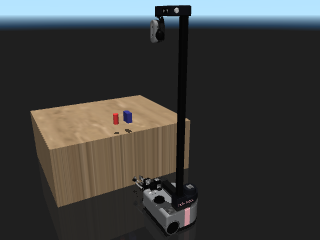

In [8]:
import importlib.resources

models_path = str(importlib.resources.files("stretch_mujoco") / "models")
xml_path = models_path + "/scene.xml"
physics = mujoco.Physics.from_xml_path(xml_path)
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [9]:
print('timestep', physics.model.opt.timestep)
print('gravity', physics.model.opt.gravity)

timestep 0.002
gravity [ 0.    0.   -9.81]


In [10]:
env = StretchPushCubeTraining(physics)
agent = PPO(state_size=env.state_size, action_size=env.action_size)

steps_per_update=int(1000_000 * physics.model.opt.timestep)
print(f"{steps_per_update=}")
# Start training
train(env, agent, steps_per_update=steps_per_update)

steps_per_update=2000


/var/folders/gp/npq3bzt53w35pj3m3m1gzqsh0000gn/T/ipykernel_95769/1971498523.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states_tensor = torch.tensor(states, dtype=torch.float32)


Episode 0: Training step complete.


PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_BADCTRL